In [29]:
# use geo_env_2022

import numpy as np
import pandas as pd # original 1.2.3
import geopandas as gpd
from shapely.geometry import Point
import pickle
import urllib.request

import matplotlib.pyplot as plt

In [2]:
location = '/home/simon/Documents/Bodies/data/UCDP'

In [3]:
def get_data(location):

    # Getting and loading views data
    print('Beginning file download UCDP...')

    url_ucdp = 'https://ucdp.uu.se/downloads/ged/ged201-csv.zip'
    path_ucdp = location + "/ged201-csv.zip"
    urllib.request.urlretrieve(url_ucdp, path_ucdp)


    # Getting and loading prio data
    print('Beginning file download PRIO...')

    url_prio = 'http://file.prio.no/ReplicationData/PRIO-GRID/priogrid_shapefiles.zip'
    path_prio = location + '/priogrid_shapefiles.zip'
    urllib.request.urlretrieve(url_prio, path_prio)

    # And move to correct location on computerome
    # gpd.read_file('zip://' + path_prio)
    prio_grid = gpd.read_file('zip://' + path_prio)
    ucdp = pd.read_csv(path_ucdp)

    return prio_grid, ucdp

In [4]:
prio_grid, ucdp = get_data(location)

Beginning file download UCDP...
Beginning file download PRIO...


/tmp/ipykernel_113727/2005915489.py:21: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  ucdp = pd.read_csv(path_ucdp)


In [5]:
def add_month_id(ucdp = ucdp): # you could also do a week_id....

    ucdp_tmp1 = ucdp.copy()

    # debug
    # print(np.sort(ucdp_tmp1['year'].unique()))

    ucdp_tmp1['year_months_start'] = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7) # Date YYYY-MM-DD
    ucdp_tmp1['year_months_end'] = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7) # Date YYYY-MM-DD


    mask1 = (ucdp_tmp1['year'] != ucdp_tmp1['year_months_start'].str.slice(start = 0, stop = 4).astype(int))
    mask2 = (ucdp_tmp1['year'] != ucdp_tmp1['year_months_end'].str.slice(start = 0, stop = 4).astype(int))

    # check problem
    # ucdp_tmp1.loc[mask1 | mask2]

    # correction. Note that end and start year for the four entries that is corrected is the same.
    ucdp_tmp1.loc[mask1 | mask2, 'year'] = ucdp_tmp1.loc[mask1 | mask2,'year_months_start'].str.slice(start = 0, stop = 4).astype(int)

    # see that it have been solved
    # ucdp_tmp1.loc[mask1 | mask2]

    # debug
    # print(np.sort(ucdp_tmp1['year'].unique()))

    # but do you need all years or just those in theb Bodies data?
    # tjeck woth views month id.. could be nice to just nail that now.

    ds_uniques = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7).unique()
    de_uniques = ucdp_tmp1['date_end'].str.slice(start = 0, stop = 7).unique() # do you need both?

    months_unique = np.union1d(ds_uniques, de_uniques)
    months_unique.sort()

    month_id = np.arange(109, months_unique.shape[0] + 109, 1) # this makes sure the month_id matches that of ViWES replication data. Just in case.

    month_df = pd.DataFrame({'month_id' : month_id, 'year_months_start' : months_unique, 'year_months_end' : months_unique})

    # I checked. There is no instance where the month id will differ if we take start or end.
    ucdp_tmp2 = ucdp_tmp1.merge(month_df[['month_id', 'year_months_start']], how = 'outer', on= 'year_months_start')
    #ucdp_tmp3 = ucdp_tmp2.merge(month_df[['month_id', 'year_months_end']], how = 'outer', on= 'year_months_end')
    #ucdp_tmp3[ucdp_tmp3['month_id_x'] == ucdp_tmp3['month_id_y']] # None


    ## just a test:

    # External
    # pkl_file = open('/media/simon/Seagate Backup Plus Drive/Articles/conflict_prediction/data/computerome/currents/preds_df_tt.pkl', 'rb')
    # currents_df = pickle.load(pkl_file)
    # pkl_file.close()

    # for y in np.sort(ucdp_tmp2['year'].unique())[1:29]:

    #     check = np.all(np.sort(ucdp_tmp2[ucdp_tmp2['year']==y]['month_id'].unique()) == currents_df[currents_df['year'] == y]['X'].unique())

    #     if check == False:

    #         print(f"{y}:{np.sort(ucdp_tmp2[ucdp_tmp2['year']==y]['month_id'].unique())}")
    #         print(f"{y}:{currents_df[currents_df['year'] == y]['X'].unique()}")
    #         print('\n')

    # it is cool.

    return(ucdp_tmp2)


In [6]:
ucdp_monthly =  add_month_id(ucdp = ucdp)


In [7]:
def trim_ucdp(ucdp = ucdp_monthly):

    ucdp_slim = ucdp[['year', 'month_id', 'priogrid_gid','best','low','high']]
    ucdp_gid = ucdp_slim.groupby(by=['priogrid_gid','month_id', 'year']).sum().reset_index() # so right now it is monthly units. you can change this..
    ucdp_gid.rename(columns={'priogrid_gid':'gid'}, inplace=True)

    ucdp_gid['log_best'] = np.log(ucdp_gid['best'] +1)
    ucdp_gid['log_low'] = np.log(ucdp_gid['low'] +1)
    ucdp_gid['log_high'] = np.log(ucdp_gid['high'] +1)

    return(ucdp_gid)

In [8]:
ucdp_gid = trim_ucdp(ucdp = ucdp_monthly)

In [9]:
ucdp_gid

,gid,month_id,year,best,low,high,log_best,log_low,log_high
0,75530,467,2018,2,2,2,1.098612,1.098612,1.098612
1,79444,147,1992,0,0,29,0.000000,0.000000,3.401197
2,79444,175,1994,86,86,86,4.465908,4.465908,4.465908
3,80318,117,1989,1,1,2,0.693147,0.693147,1.098612
4,80318,135,1991,1,1,1,0.693147,0.693147,0.693147
...,...,...,...,...,...,...,...,...,...
82087,216561,292,2004,5,5,5,1.791759,1.791759,1.791759
82088,216561,436,2016,3,3,4,1.386294,1.386294,1.609438
82089,216561,437,2016,3,3,3,1.386294,1.386294,1.386294
82090,216561,438,2016,14,14,14,2.708050,2.708050,2.708050


In [10]:
prio_grid

,gid,xcoord,ycoord,col,row,geometry
0,259168,163.75,89.75,688,360,"POLYGON ((163.50000 89.50000, 163.50000 90.000..."
1,259169,164.25,89.75,689,360,"POLYGON ((164.00000 89.50000, 164.00000 90.000..."
2,259170,164.75,89.75,690,360,"POLYGON ((164.50000 89.50000, 164.50000 90.000..."
3,259171,165.25,89.75,691,360,"POLYGON ((165.00000 89.50000, 165.00000 90.000..."
4,259172,165.75,89.75,692,360,"POLYGON ((165.50000 89.50000, 165.50000 90.000..."
...,...,...,...,...,...,...
259195,43,-158.75,-89.75,43,1,"POLYGON ((-159.00000 -90.00000, -159.00000 -89..."
259196,44,-158.25,-89.75,44,1,"POLYGON ((-158.50000 -90.00000, -158.50000 -89..."
259197,45,-157.75,-89.75,45,1,"POLYGON ((-158.00000 -90.00000, -158.00000 -89..."
259198,46,-157.25,-89.75,46,1,"POLYGON ((-157.50000 -90.00000, -157.50000 -89..."


In [11]:
up_df = ucdp_gid.merge(prio_grid, how= 'left', on = 'gid')
type(up_df)

pandas.core.frame.DataFrame

In [12]:
up_df

,gid,month_id,year,best,low,high,log_best,log_low,log_high,xcoord,ycoord,col,row,geometry
0,75530,467,2018,2,2,2,1.098612,1.098612,1.098612,144.75,-37.75,650,105,"POLYGON ((144.50000 -38.00000, 144.50000 -37.5..."
1,79444,147,1992,0,0,29,0.000000,0.000000,3.401197,-58.25,-34.75,244,111,"POLYGON ((-58.50000 -35.00000, -58.50000 -34.5..."
2,79444,175,1994,86,86,86,4.465908,4.465908,4.465908,-58.25,-34.75,244,111,"POLYGON ((-58.50000 -35.00000, -58.50000 -34.5..."
3,80318,117,1989,1,1,2,0.693147,0.693147,1.098612,18.75,-34.25,398,112,"POLYGON ((18.50000 -34.50000, 18.50000 -34.000..."
4,80318,135,1991,1,1,1,0.693147,0.693147,0.693147,18.75,-34.25,398,112,"POLYGON ((18.50000 -34.50000, 18.50000 -34.000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82087,216561,292,2004,5,5,5,1.791759,1.791759,1.791759,100.25,60.25,561,301,"POLYGON ((100.00000 60.00000, 100.00000 60.500..."
82088,216561,436,2016,3,3,4,1.386294,1.386294,1.609438,100.25,60.25,561,301,"POLYGON ((100.00000 60.00000, 100.00000 60.500..."
82089,216561,437,2016,3,3,3,1.386294,1.386294,1.386294,100.25,60.25,561,301,"POLYGON ((100.00000 60.00000, 100.00000 60.500..."
82090,216561,438,2016,14,14,14,2.708050,2.708050,2.708050,100.25,60.25,561,301,"POLYGON ((100.00000 60.00000, 100.00000 60.500..."


In [13]:
pu_df = prio_grid.merge(ucdp_gid, how = 'right', on = 'gid') # this way you keep it as as geopandas - but is that needed?
type(pu_df)

geopandas.geodataframe.GeoDataFrame

In [14]:
pu_df

,gid,xcoord,ycoord,col,row,geometry,month_id,year,best,low,high,log_best,log_low,log_high
0,75530,144.75,-37.75,650,105,"POLYGON ((144.50000 -38.00000, 144.50000 -37.5...",467,2018,2,2,2,1.098612,1.098612,1.098612
1,79444,-58.25,-34.75,244,111,"POLYGON ((-58.50000 -35.00000, -58.50000 -34.5...",147,1992,0,0,29,0.000000,0.000000,3.401197
2,79444,-58.25,-34.75,244,111,"POLYGON ((-58.50000 -35.00000, -58.50000 -34.5...",175,1994,86,86,86,4.465908,4.465908,4.465908
3,80318,18.75,-34.25,398,112,"POLYGON ((18.50000 -34.50000, 18.50000 -34.000...",117,1989,1,1,2,0.693147,0.693147,1.098612
4,80318,18.75,-34.25,398,112,"POLYGON ((18.50000 -34.50000, 18.50000 -34.000...",135,1991,1,1,1,0.693147,0.693147,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82087,216561,100.25,60.25,561,301,"POLYGON ((100.00000 60.00000, 100.00000 60.500...",292,2004,5,5,5,1.791759,1.791759,1.791759
82088,216561,100.25,60.25,561,301,"POLYGON ((100.00000 60.00000, 100.00000 60.500...",436,2016,3,3,4,1.386294,1.386294,1.609438
82089,216561,100.25,60.25,561,301,"POLYGON ((100.00000 60.00000, 100.00000 60.500...",437,2016,3,3,3,1.386294,1.386294,1.386294
82090,216561,100.25,60.25,561,301,"POLYGON ((100.00000 60.00000, 100.00000 60.500...",438,2016,14,14,14,2.708050,2.708050,2.708050


**Really you need to have infered all coordinates before oyou get here...**

In [15]:
def get_bodies_data():    
    
    data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

    with open(f'{data_dir}df_od_coordinates_full.pkl', 'rb') as file:
        bodies_df = pickle.load(file)

    return(bodies_df)

In [17]:
bodies_df = get_bodies_data()

In [18]:
type(bodies_df)

pandas.core.frame.DataFrame

In [24]:
geometry = [Point(xy) for xy in zip(bodies_df['longitude_full'], bodies_df['latitude_full'])]
crs = {'init':'EPSG:4326'} #check that this is right!!!

# Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.
#Left CRS: +init=epsg:4326 +type=crs
#Right CRS: EPSG:4326


bodies_gdf = gpd.GeoDataFrame(bodies_df, crs = crs, geometry = geometry)

/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [25]:
bodies_gdf

,person_mean,person_median,person_fasterR50,person_fasterR101,person_fasterX101,person_retinaR50,person_retinaR101,child_mean,child_median,child_retinaR50,...,object name,latitude_p,longitude_p,date,location_annot,distance_days,pred_idx,longitude_full,latitude_full,geometry
0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,2008-12-27,0,0 days,184.0,44.378799,33.302431,POINT (44.37880 33.30243)
1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,2009-09-01,0,0 days,906.0,44.378799,33.302431,POINT (44.37880 33.30243)
2,1.6,2.0,2.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,...,NaN,NaN,NaN,2007-10-12,0,0 days,582.0,44.378799,33.302431,POINT (44.37880 33.30243)
3,2.8,3.0,2.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,2005-11-20,0,0 days,8226.0,41.037860,34.427567,POINT (41.03786 34.42757)
4,1.8,2.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,...,NaN,NaN,NaN,2005-11-15,0,0 days,7896.0,41.046437,34.390889,POINT (41.04644 34.39089)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152436,0.6,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,34.376222,43.64465,2004-01-14,1,NaT,NaN,44.152789,34.001313,POINT (44.15279 34.00131)
152437,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,...,NaN,34.376222,43.64465,2004-01-15,1,NaT,NaN,44.152789,34.001313,POINT (44.15279 34.00131)
152438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,34.376222,43.64465,2004-01-15,1,NaT,NaN,44.152789,34.001313,POINT (44.15279 34.00131)
152439,4.8,5.0,5.0,5.0,5.0,5.0,4.0,1.5,1.5,2.0,...,NaN,34.376222,43.64465,2004-01-14,1,NaT,NaN,44.152789,34.001313,POINT (44.15279 34.00131)


<AxesSubplot:>

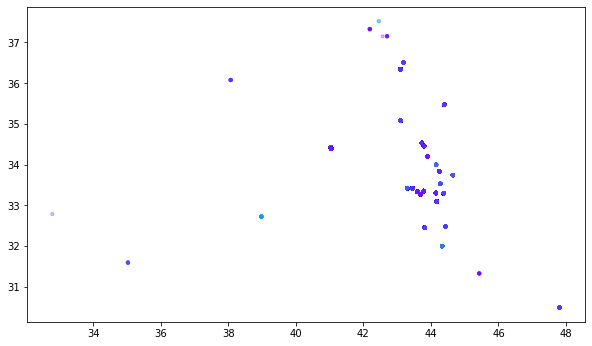

In [30]:
fig, ax = plt.subplots(figsize = (10,10))
bodies_gdf.plot(column = 'person_mean', ax=ax, cmap = 'rainbow', markersize = 10, alpha = 0.3 )

In [31]:
combined_df = gpd.sjoin(bodies_gdf, pu_df, how="right", op='within')

/home/simon/anaconda3/envs/geo_env_2022/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_113727/3710844654.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  combined_df = gpd.sjoin(bodies_gdf, pu_df, how="right", op='within')


In [15]:
bodies_gdf = gpd.GeoDataFrame(bodies_df)
bodies_gdf.set_geometry()

1

In [ ]:
geometry = [Point(xy) for xy in zip(bodies_df['longitude_full'], bodies_df['latitude_full'])]

In [22]:
Point(bodies_df[['latitude_full', 'longitude_full']])

KeyError: 0

In [221]:
def elong_df(df, df_w_time, temporal_unit):

    """While a bit hacky, this works. It extents the prio grid to match any temporal unit"""

    t = sorted(df_w_time[temporal_unit].unique())
    df[temporal_unit] = t[0]
    concat_df = df.copy()

    for i,j in enumerate(t[1:]):

        df_temp = df.copy()
        df_temp[temporal_unit] = j

        concat_df = pd.concat([concat_df, df_temp])
    
    concat_df.reset_index(inplace = True)
    return concat_df 

In [222]:
# maybe not the way...
# prio_grid_t = elong_df(prio_grid, ucdp_gid, 'month_id')

KeyboardInterrupt: 

In [ ]:
# maybe not the way...

In [ ]:

def elong_df(df, df_w_years):

    """While a bit hacky, this works. It extents the prio grid to match any temporal unit"""

    years = sorted(df_w_years['year'].unique())
    df['year'] = years[0]
    concat_df = df.copy()

    for i,j in enumerate(years[1:]):

        df_temp = df.copy()
        df_temp['year'] = j

        concat_df = pd.concat([concat_df,df_temp])
    
    concat_df.reset_index(inplace = True)
    return concat_df 


In [ ]:

def make_df(prio_grid, ucdp):

    print('Creating DF...')

    ucdp_gid = trim_ucdp(ucdp=ucdp)
    prio_grid_yearly = elong_df(prio_grid, ucdp_gid)

    grid_ucdp =  pd.merge(prio_grid_yearly, ucdp_gid, how = 'left', on = ['gid', 'year'])
    grid_ucdp.fillna({'best' : 0, 'low' : 0, 'high' : 0, 'log_best' : 0, 'log_low' : 0, 'log_high' : 0}, inplace = True)

    grid_ucdp = grid_ucdp[['gid', 'xcoord', 'ycoord', 'year', 'best', 'low', 'high', 'log_best', 'log_low', 'log_high']].copy() # remove the everything also the geo col.

    grid_ucdpS = grid_ucdp.sort_values(['year', 'ycoord', 'xcoord'], ascending = [True, False, True])

    # try to keep the jazz
    #grid_ucdpS = grid_ucdpS[['gid','best', 'low',  'high', 'log_best', 'log_low', 'log_high']].copy() # remove the everything also the geo col. But keep gid. Why not.

    x_dim = grid_ucdp['xcoord'].unique().shape[0]
    y_dim = grid_ucdp['ycoord'].unique().shape[0]
    z_dim = grid_ucdp['year'].unique().shape[0]

    ucpd_vol = np.array(grid_ucdpS).reshape((z_dim, y_dim, x_dim, -1))

    return ucpd_vol